# Análisis de Siniestros Viales en Guadalajara y Zapopan (2019–2025)
## Notebook 04: Clustering y Detección de Zonas Críticas

En este notebook aplicaremos técnicas de agrupamiento (clustering) para identificar zonas con alta concentración de accidentes.

Probaremos dos enfoques:
- **DBSCAN**: ideal para detectar agrupaciones de puntos basadas en densidad.
- **KMeans**: útil para dividir el espacio geográfico en zonas similares, aunque no necesariamente conectadas.

Nuestro objetivo es comparar ambos métodos y elegir el más útil para definir zonas prioritarias de intervención.


---

In [53]:
import pandas as pd
import geopandas as gpd

# Cargar GeoDataFrame desde el archivo con geometría
gdf = gpd.read_file("../data/accidentes_shapes.geojson")

# Extraer solo coordenadas
coords = gdf[["geometry"]].copy()
coords["x"] = coords.geometry.x
coords["y"] = coords.geometry.y


## DBSCAN: Agrupamiento basado en densidad

DBSCAN detecta agrupaciones de puntos cercanos entre sí, lo que permite identificar "zonas calientes" reales, sin necesidad de definir cuántas queremos.

Cada grupo se define con dos parámetros:
- `eps`: distancia máxima entre puntos del mismo grupo.
- `min_samples`: número mínimo de puntos para formar un clúster.

Los puntos etiquetados como `-1` son considerados ruido o puntos aislados.


In [54]:
from sklearn.cluster import DBSCAN
import numpy as np

# Convertir a arreglo de coordenadas
X = coords[["x", "y"]].values

# Aplicar DBSCAN ajustando parámetros
db = DBSCAN(eps=0.0035, min_samples=15).fit(X)

# Añadir etiquetas al GeoDataFrame
gdf["cluster_dbscan"] = db.labels_


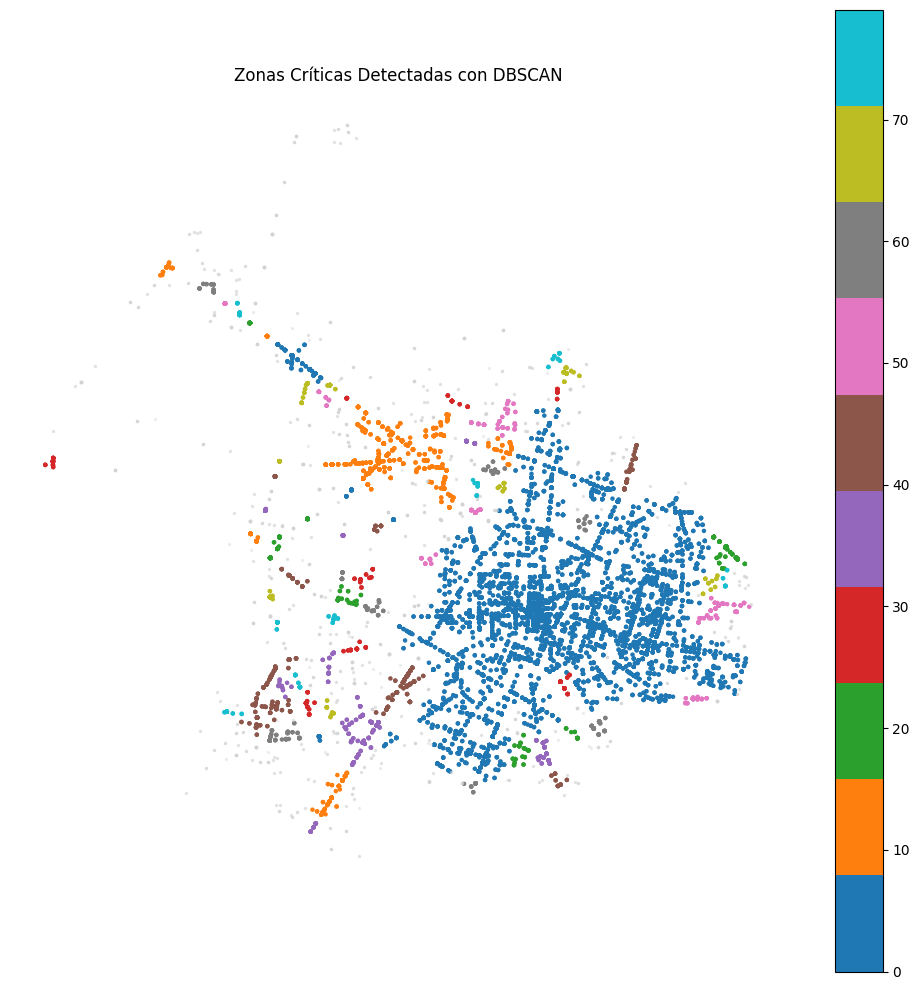

In [55]:
import matplotlib.pyplot as plt

# Visualización
fig, ax = plt.subplots(figsize=(10, 10))
gdf[gdf["cluster_dbscan"] != -1].plot(column="cluster_dbscan", ax=ax, cmap="tab10", markersize=5, legend=True)
gdf[gdf["cluster_dbscan"] == -1].plot(ax=ax, color="lightgrey", markersize=2, alpha=0.3)
plt.title("Zonas Críticas Detectadas con DBSCAN")
plt.axis("off")
plt.tight_layout()
plt.savefig("../outputs/dbscan_segmentacion_geografica.png", dpi=300)
plt.show()


## Evaluación de DBSCAN ajustado

Tras ajustar los parámetros de DBSCAN (`eps=0.0035`, `min_samples=15`), se obtuvo una agrupación mucho más útil y realista de las zonas críticas:

- Se identificaron zonas densas de accidentes de manera clara, especialmente en el centro-sur de Guadalajara.
- También se formaron clústeres relevantes en ejes viales importantes de Zapopan y zonas industriales.

---

## Estadísticas descriptivas por clúster DBSCAN

En esta sección se presentan los principales indicadores por clúster:

- Total de siniestros registrados.
- Número y proporción de personas fallecidas, lesionadas e ilesas.
- Usuarios más involucrados (peatones, motociclistas, vehículos particulares).

Estos indicadores permiten detectar clústeres con mayor gravedad o vulnerabilidad, no solo por volumen, sino por el tipo de víctimas y consecuencias. Esta información es clave para priorizar intervenciones por zona.


In [56]:
# Filtrar solo puntos que pertenecen a un clúster válido
gdf_valid = gdf[gdf["cluster_dbscan"] != -1].copy()

# Agrupar por clúster
cluster_summary = gdf_valid.groupby("cluster_dbscan").agg(
    total_siniestros=("cluster_dbscan", "count"),
    fallecidos=("consecuencia", lambda x: (x.str.lower() == "fallecido").sum()),
    lesionados=("consecuencia", lambda x: (x.str.lower() == "lesionado").sum()),
    ilesos=("consecuencia", lambda x: (x.str.lower() == "ileso").sum()),
    usuarios_peaton=("tipo_usuario", lambda x: (x.str.lower().str.contains("peaton")).sum()),
    usuarios_moto=("tipo_usuario", lambda x: (x.str.lower().str.contains("moto")).sum()),
    usuarios_particular=("tipo_usuario", lambda x: (x.str.lower().str.contains("vehiculo particular")).sum())
)

# Convertir todos los valores a porcentaje del total de siniestros
for col in ["fallecidos", "lesionados", "ilesos", "usuarios_peaton", "usuarios_moto", "usuarios_particular"]:
    cluster_summary[f"% {col}"] = (cluster_summary[col] / cluster_summary["total_siniestros"]) * 100

# Seleccionar solo columnas de porcentaje y total
cols_to_show = ["total_siniestros"] + [col for col in cluster_summary.columns if col.startswith("%")]
cluster_summary = cluster_summary[cols_to_show]

# Ordenar por total de siniestros
cluster_summary = cluster_summary.sort_values(by="total_siniestros", ascending=False)

cluster_summary.to_csv("../outputs/dbscan_statistics.csv")

# Mostrar top 10
import pandas as pd
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Resumen por Clúster DBSCAN", dataframe=cluster_summary.head(10))


Resumen por Clúster DBSCAN


---

## Clustering con KMeans

In [57]:
from sklearn.cluster import KMeans

# Usamos las coordenadas geográficas como entrada
X = gdf[["geometry"]].copy()
X["x"] = X.geometry.x
X["y"] = X.geometry.y
X = X[["x", "y"]].values

# Definir número de clústeres probando con distintos valores
k = 6
kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)

# Agregar etiquetas al GeoDataFrame
gdf["cluster_kmeans"] = kmeans.labels_


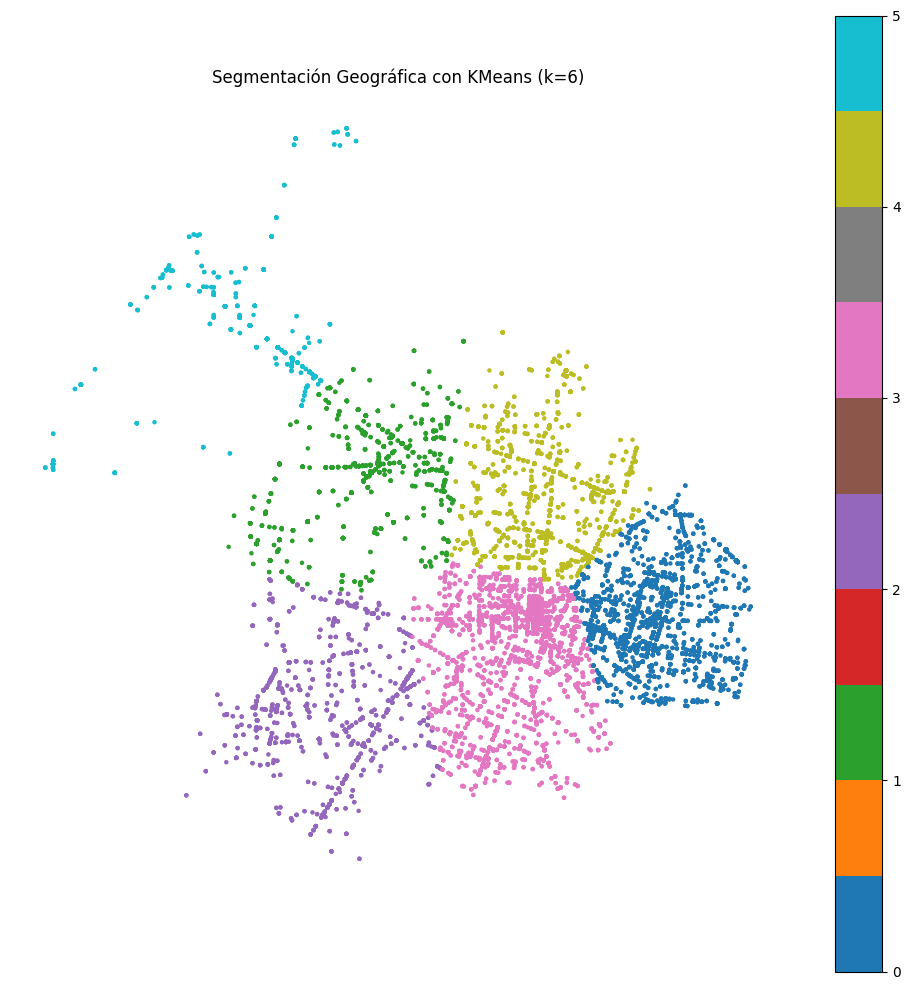

In [58]:
import matplotlib.pyplot as plt

# Graficar clústeres KMeans
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column="cluster_kmeans", ax=ax, cmap="tab10", markersize=5, legend=True)
plt.title(f"Segmentación Geográfica con KMeans (k={k})")
plt.axis("off")
plt.tight_layout()
plt.savefig("../outputs/kmeans_segmentacion_geografica.png", dpi=300)
plt.show()


## KMeans: Segmentación del territorio en zonas fijas

KMeans permite dividir el espacio urbano en un número determinado de regiones con características similares en términos de distribución de siniestros.

En este caso, se utilizó `k = 6` para generar seis zonas, lo que puede resultar útil para análisis comparativos, planeación territorial o asignación de recursos.

A diferencia de DBSCAN, KMeans no considera densidad de puntos, sino que agrupa los datos en regiones compactas, aunque estas pueden no reflejar zonas críticas reales.


---

## Estadísticas descriptivas por clúster KMeans

Este análisis permite comparar las diferentes zonas creadas por KMeans en términos de cantidad de siniestros, severidad de las consecuencias y tipo de usuario involucrado.

A diferencia de DBSCAN, KMeans divide toda el área metropolitana en regiones completas, por lo que este enfoque es útil para comparar **zonas geográficas homogéneas** y proponer acciones diferenciadas por sector.



In [59]:
kmeans_summary = gdf.groupby("cluster_kmeans").agg(
    total_siniestros=("cluster_kmeans", "count"),
    fallecidos=("consecuencia", lambda x: (x.str.lower() == "fallecido").sum()),
    lesionados=("consecuencia", lambda x: (x.str.lower() == "lesionado").sum()),
    ilesos=("consecuencia", lambda x: (x.str.lower() == "ileso").sum()),
    usuarios_peaton=("tipo_usuario", lambda x: (x.str.lower().str.contains("peaton")).sum()),
    usuarios_moto=("tipo_usuario", lambda x: (x.str.lower().str.contains("moto")).sum()),
    usuarios_particular=("tipo_usuario", lambda x: (x.str.lower().str.contains("vehiculo particular")).sum())
)

# Calcular porcentajes relativos al total de siniestros
for col in ["fallecidos", "lesionados", "ilesos", "usuarios_peaton", "usuarios_moto", "usuarios_particular"]:
    kmeans_summary[f"% {col}"] = (kmeans_summary[col] / kmeans_summary["total_siniestros"]) * 100

# Seleccionar columnas a mostrar
cols_to_show = ["total_siniestros"] + [col for col in kmeans_summary.columns if col.startswith("%")]
kmeans_summary = kmeans_summary[cols_to_show]

# Ordenar por total de siniestros
kmeans_summary = kmeans_summary.sort_values(by="total_siniestros", ascending=False)

kmeans_summary.to_csv("../outputs/kmeans_statistics.csv")

# Mostrar resumen
kmeans_summary.head(6)
import ace_tools_open as tools; tools.display_dataframe_to_user(name="Resumen por Clúster K-Means", dataframe=kmeans_summary.head(6))


Resumen por Clúster K-Means


## Conclusiones del Clustering

Ambos métodos ofrecen perspectivas complementarias sobre la distribución geográfica de los siniestros viales:

- **DBSCAN** destaca por su capacidad de detectar zonas de alta concentración de accidentes. Es especialmente útil para identificar puntos críticos y planear intervenciones específicas.

- **KMeans**, por otro lado, divide el área metropolitana en regiones comparables. Aunque no representa la densidad real de los accidentes, permite análisis comparativos y planificación por zonas.
